# Solenoid Magnetorquer Optimization
Hayden Gosch - Husky Satellite Lab

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Global Variables (everything is in meter-equivalent!)
r_tot = 100 # ohms
current = 9/r_tot # amps
rho = 1.77e-8 # ohm-meter
dens = 1e6 # mass density in g/m^3
u0 = 1.256637e-6 # magnetic constant
u_r = 5000 # core material magnetic constant (iron)

In [10]:
def b_field(n: int, length: float, rel_perm: float = 1):
    return rel_perm*((n*current))

def core_mass(l_c: float, r_c: float, dens: float) -> float:
    """
    Accepts length and radius of core (m), along with density
    of core material (g/m^3) and returns mass in g
    """
    return ((np.pi*(r_c**2))*(l_c*dens))

def permeability(l_c: float, r_c: float) -> float:
    """
    Accepts length and radius of core and calculates the effective
    magnetic permeability constant for the material specified
    in global variables.
    Derives formula for effective permeability from: 
    
    https://www.aero.iitb.ac.in/satelliteWiki/index.php/
        Magnetorquers#Effect_of_the_ferromagnetic_core
    """
    d = 2*r_c
    # calculate demagnetization factor
    demag = (4 * (np.log(l_c / r_c) - 1)) / ((l_c / r_c)**2 - (4 * np.log(l_c / r_c)))
    return 1 + ((u_r - 1) / (1 + (demag * (u_r - 1))))


In [4]:
def max_loops(rad_core: float, rad_tot: float, sol_len: float, xs_area: float) -> (int, float, float):
    """
    Accepts dimensions of the solenoid (core radius, max radius with wires, and length),
    as well as the cross-sectional area of a wire and returns the total number of
    loops that can be wound around the core based on global parameters, amount of wire
    left over, as well as the total mass of the wire in grams.
    """
    r_w = np.sqrt(xs_area / np.pi) # wire radius
    l_w = r_tot * xs_area / rho # wire length
    mass = l_w * xs_area * dens
    radial_limit = (rad_tot - rad_core) // (2 * r_w) # total number of radial layers
    axial_limit = sol_len // (2 * r_w) # total num axial layers
    n = 0 # loop counter
    l = 1 # layer counter
    while l_w > 0:
        n += 1
        # check if a layer is full
        # (no more loops can be added length-wise):
        if n % axial_limit == 0:
            l += 1
        if l > radial_limit:
            return n, mass, l_w
        l_w -= 2*np.pi*(rad_core + 2*r_w*l)
    return n, mass, 0
        

In [5]:
# Test should yield 12 (volume constraint)
print(max_loops(1, 3, 6, 0.25*np.pi)[0])

12


In [6]:
# Test should yield 5 (length constraint)
print(max_loops(1/(2*np.pi), 100, 20, 8.85e-10)[0])

5


## Test Run
### Solenoid with length 10cm, core radius 0.5cm, and total radius of 1cm
Typical wires that can support currents around the ~0.9A we plan to use range in diameter from 0.2032mm to 0.645mm. To make a smooth looking graph, I will plot 100 data points between these two values.

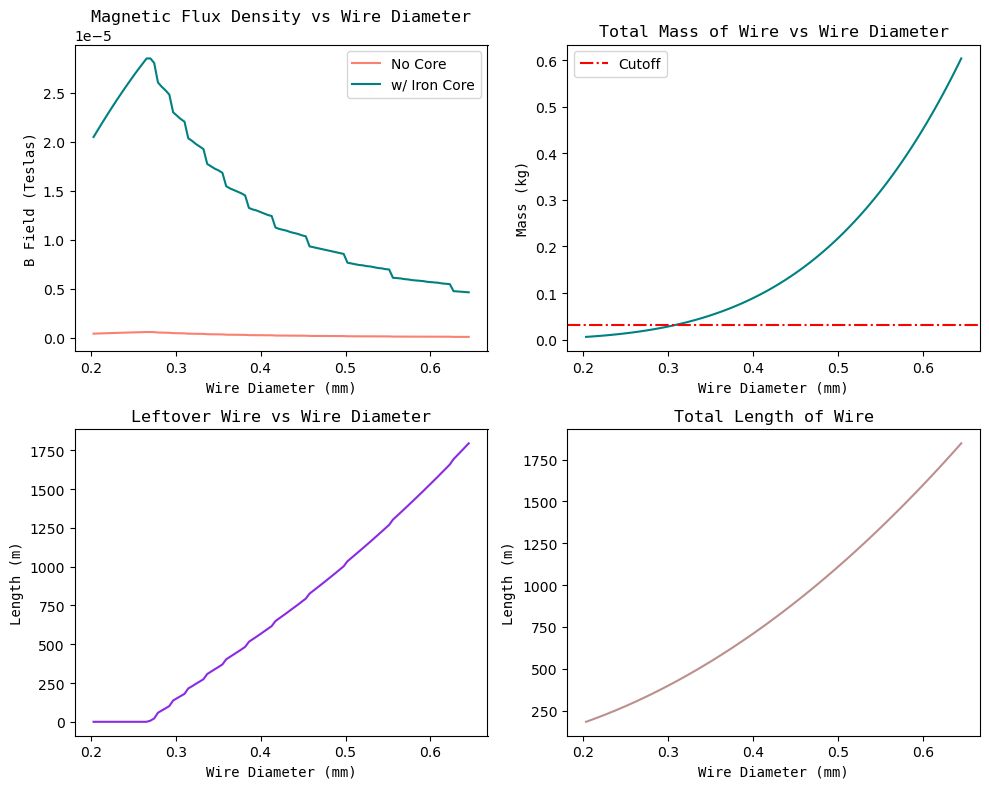

In [15]:
%matplotlib inline 
# dimensions
l_s = 10e-2
r_c = 5e-3
r_t = 1e-2
diameters = np.linspace(0.2032, 0.64516, 100) # diameters
xs_areas = [np.pi*(((d/2)*1e-3)**2) for d in diameters] # convert to cross-sectional area
no_core = [np.pi * ((r_t / 2)**2) * b_field(max_loops(r_c, r_t, l_s, area)[0], l_s) for area in xs_areas]
with_core = [b * permeability(l_s, r_c) for b in no_core]
mass = [(max_loops(r_c, r_t, l_s, area)[1])/1000 for area in xs_areas]
leftover = [(max_loops(r_c, r_t, l_s, area)[2]) for area in xs_areas]
tot_len = [r_tot * xs_area / rho for xs_area in xs_areas]

# plot
fig = plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.plot(diameters, no_core, color='salmon', label='No Core')
plt.plot(diameters, with_core, color='teal', label='w/ Iron Core')
plt.legend()
plt.title('Magnetic Flux Density vs Wire Diameter', family='monospace')
plt.ylabel('B Field (Teslas)', family='monospace')
plt.xlabel('Wire Diameter (mm)', family='monospace')
plt.subplot(222)
plt.plot(diameters, mass, color='teal')
plt.axhline(y = 0.032, color = 'r', linestyle = '-.', label='Cutoff')
plt.title('Total Mass of Wire vs Wire Diameter', family='monospace')
plt.ylabel('Mass (kg)', family='monospace')
plt.xlabel('Wire Diameter (mm)', family='monospace')
plt.legend()
plt.subplot(223)
plt.plot(diameters, leftover, color='blueviolet')
plt.ylabel('Length (m)', family='monospace')
plt.xlabel('Wire Diameter (mm)', family='monospace')
plt.title('Leftover Wire vs Wire Diameter', family='monospace')
plt.subplot(224)
plt.plot(diameters, tot_len, color='rosybrown')
plt.title('Total Length of Wire', family='monospace')
plt.ylabel('Length (m)', family='monospace')
plt.xlabel('Wire Diameter (mm)', family='monospace')
plt.tight_layout()
plt.show()

## Optimization
From inspection of the above graphs, it can be noted that increasing wire diameter has diminishing returns with regards to magnetic flux density, while the total mass of the wire increases exponentially. Because of this, it seems intuitive that the ideal design balance these two factors. In this case, the optimal wire diameter is probably around 0.2mm, but what about for other sized solenoids? Which solenoid geometry is the most efficient?

#### Constraints:
1. Total mass of solenoid + core is no more than 30 grams
2. Wire gauge must be rated for 0.09 A
3. No more than 2cm leftover wire


In [12]:
# Test Parameters
max_mass = 30 # grams
diameters = [0.2032, 0.22606, 0.254, 0.28702, 0.32004] # diameters (mm) of suitable wire
xs_areas = [np.pi*(((d/2)*1e-3)**2) for d in diameters] # wire cross-sectional areas
lens = np.linspace(2e-2, 8e-2, 14) # lengths from 2 to 8cm, incrementing by 0.5cm
core_radii = np.linspace(1e-3, 1e-2, 11) # core radius from 1mm to 10mm, incrementing by 1mm
total_radii = np.linspace(1e-3, 1.5e-2, 16) # total radii of solenoid from 1mm to 15mm, incrementing by 1mm

# Constants
u_r = 5000 # core material magnetic constant (iron)
dens = 1e6 # wire mass density in g/m^3
cr_dens = 7.8e6 # core mass density in g/m^3

# Initialize results:
max_flux = 0
opt_area = 0
opt_len = 0
opt_core_rad = 0
opt_tot_rad = 0

# Optimize:
for xs_area in xs_areas:
    for length in lens:
        for r_c in core_radii:
            for r_t in total_radii:
                if (r_t > r_c): # check that total radius is greater than core radius
                    # Calculate number of loops, wire mass, and leftover wire:
                    n_loops, wire_mass, leftover = max_loops(r_c, r_t, length, xs_area)
                    # calculate core mass:
                    c_m = core_mass(length, r_c, cr_dens)
                    # check that core + wire mass is less than the maximum allowed mass
                    # and that there is less than 2cm of leftover wire:
                    if (c_m + wire_mass <= max_mass) and (leftover <= 2e-2):
                        perm = permeability(length, r_c)
                        # calculate magnetic field
                        flux = np.pi * ((r_t / 2)**2) * perm * b_field(n_loops, length)
                        # check if this field is greater than max field seen so far
                        if (flux > max_flux):
                            max_flux = flux
                            opt_area = xs_area
                            opt_len = length
                            opt_core_rad = r_c
                            opt_tot_rad = r_t

# Report results                            
print('Maximum Magnetic Flux Acheived was: ', max_flux, ' Teslas')
print('Optimal Wire Diameter:              ', 2000*(np.sqrt(opt_area/np.pi)), ' mm')
print('Optimal Solenoid Length:            ', 100*opt_len, ' cm')
print('Optimal Core Radius:                ', 1000*opt_core_rad, ' mm')
print('Optimal Total Solenoid Radius:      ', 1000*opt_tot_rad, ' mm')

Maximum Magnetic Flux Acheived was:  0.0010303655321894061  Teslas
Optimal Wire Diameter:               0.28702000000000005  mm
Optimal Solenoid Length:             8.0  cm
Optimal Core Radius:                 1.0  mm
Optimal Total Solenoid Radius:       15.0  mm


## Results
- Maximum Magnetic Field:         *0.001 Teslas (1.003 Gauss)*
- Optimal Wire Diameter:          *0.28702 mm*
- Optimal Length of Solenoid:     *4.77 cm*
- Optimal Radius of Core:         *1.0 mm*
- Optimal Radius of Solenoid:     *15.0 mm*